In [1]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

import shutil
from sklearn.model_selection import train_test_split

sys.path.append('../modeling') # Adds the folder ‘modeling’ where our scripts are stored to the path
from preprocessing import df_from_directory, plot_color_distribution, rename_subfolder 

RSEED = 42
DATASET_PATH = '../data/images/' # Path to the parent folder where the original data is stored

# 1. Load the Data

1. Download the dataset [Plant Diseases Training Dataset](https://www.kaggle.com/datasets/nirmalsankalana/plant-diseases-training-dataset/data)
2. Place the downloaded `archive.zip` file inside the folder `data` in this repo
3. Run `unzip archive.zip` to extract the files. This creates the new folder `data/` with subfolders for all images.
4. Rename `data/data/[subfolders]` to `data/all_images/[subfolders]`

In [ ]:
os.rename("../data/data", "../data/images")

5. Make a DataFrame for EDA

In [2]:
# Make a DataFrame that includes the image path and the class (folder name)

df = df_from_directory(DATASET_PATH)

# 2. EDA

## 2.1. Prepare data

First, lets have a look at our DataFrame df to get a general overview.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95859 entries, 0 to 95858
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  95859 non-null  object
 1   class       95859 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


This looks good, there are 95868 images. Or are there other files besides images? Let's check!

In [5]:
file_types = {}

def count_file_types(folder): 
    for root, dirs, files in os.walk(folder): 
        for file in files: # Get the file extension 
            file_extension = os.path.splitext(file)[1][1:].lower()
            file_types[file_extension] = file_types.get(file_extension, 0) + 1

folder_path = '../data'
count_file_types(folder_path)

for file_type, count in file_types.items(): print(f"{file_type}: {count}")

: 1
zip: 1
jpg: 93336
jpeg: 2522
png: 1


This looks good: jpg, jpeg and png are all image files that we can work with. The .zip file can be deleted now since we don't need it any longer.  
Next, we want to get an impression of the distribution of our different classes.

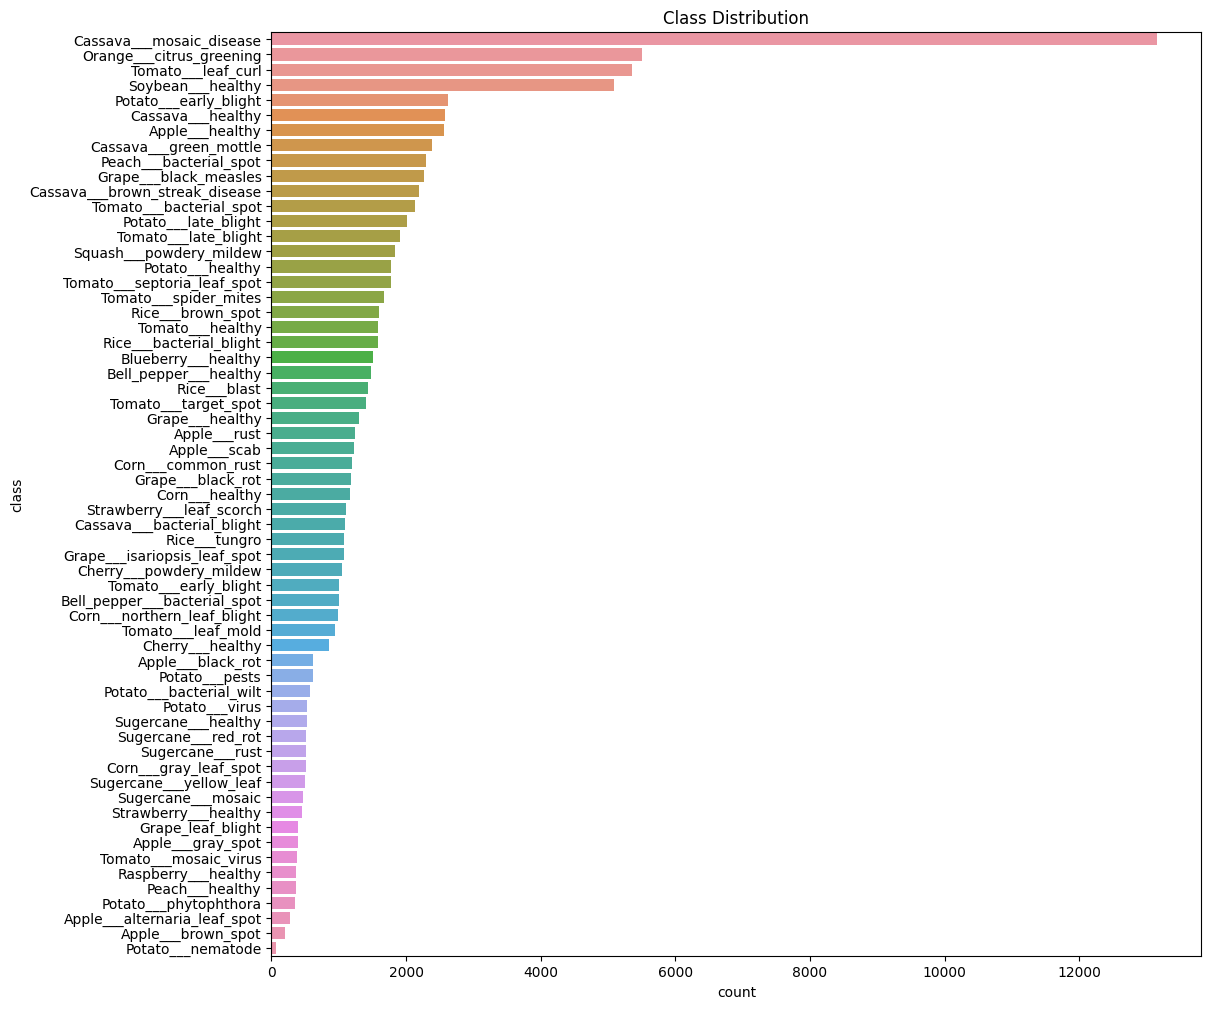

In [6]:
# Check the distribution of classes
class_counts = df['class'].value_counts()
plt.figure(figsize=(12, 12))
sns.countplot(y='class', data=df, order=class_counts.index)
plt.title('Class Distribution')
plt.show()

Looking at this carefully reveals that all classes follow the same naming convention: `[plant]___[disease or healthy]`. As we want to use the folder names as class labels later on, it's crucial that ALL folders are named in this manner. Let's check that.

In [7]:
problematic_rows = df[df['class'].apply(lambda x: len(x.split('___')) < 2)]
print("Problematic Rows:")
print(problematic_rows)

Problematic Rows:
                                              image_path              class
22632  ../data/images/Grape_leaf_blight/5d261e2e-5541...  Grape_leaf_blight
22633  ../data/images/Grape_leaf_blight/d5a4f65f-7d27...  Grape_leaf_blight
22634  ../data/images/Grape_leaf_blight/54a17d93-22ce...  Grape_leaf_blight
22635  ../data/images/Grape_leaf_blight/04d59dc2-2133...  Grape_leaf_blight
22636  ../data/images/Grape_leaf_blight/d5d5532f-7fbd...  Grape_leaf_blight
...                                                  ...                ...
23027  ../data/images/Grape_leaf_blight/9c6fb219-6111...  Grape_leaf_blight
23028  ../data/images/Grape_leaf_blight/ba8778b1-8caf...  Grape_leaf_blight
23029  ../data/images/Grape_leaf_blight/b59823b4-69a0...  Grape_leaf_blight
23030  ../data/images/Grape_leaf_blight/2c135c30-428c...  Grape_leaf_blight
23031  ../data/images/Grape_leaf_blight/6e4d7942-a265...  Grape_leaf_blight

[400 rows x 2 columns]


Oh no! There are some problematic rows: `Grape_leaf_blight` should be `Grape___leaf_blight`. Let's fix that.

In [9]:
rename_subfolder(
    parent_dir = DATASET_PATH,
    subfolder_name = "Grape_leaf_blight",
    new_name = "Grape___leaf_blight"
)

Grape_leaf_blight renamed to Grape___leaf_blight successfully.


'Grape___leaf_blight'

We'll then update our df with the correct `Grape___leaf_blight` directory.


In [3]:
df = df_from_directory(DATASET_PATH)

Great! We now have an upated df to work with.  
In the next steps, we'll extract the plant name and disease type from the `class`label.

In [4]:
# Extract plant types from class names
df['plant_type'] = df['class'].apply(lambda x: x.split('___')[0])

# Count the occurrences of each plant type
plant_type_counts = df['plant_type'].value_counts()

# Display the count of each plant type
print(plant_type_counts)

plant_type
Cassava        21397
Tomato         18160
Potato          8552
Apple           6533
Grape           6232
Rice            5704
Orange          5507
Soybean         5090
Corn            3852
Peach           2657
Sugercane       2521
Bell_pepper     2475
Cherry          1906
Squash          1835
Strawberry      1565
Blueberry       1502
Raspberry        371
Name: count, dtype: int64


In [5]:
# Extract disease types from class names
df['disease_type'] = df['class'].apply(lambda x: x.split('___')[1])

# Count the occurrences of each disease type
disease_type_counts = df['disease_type'].value_counts()

# Display the count of each disease type
print(disease_type_counts)

disease_type
healthy                 21615
mosaic_disease          13158
citrus_greening          5507
bacterial_spot           5421
leaf_curl                5357
late_blight              3929
early_blight             3628
powdery_mildew           2887
bacterial_blight         2671
green_mottle             2386
black_measles            2271
brown_streak_disease     2189
brown_spot               1806
black_rot                1801
septoria_leaf_spot       1771
rust                     1755
spider_mites             1676
blast                    1440
target_spot              1404
scab                     1222
common_rust              1192
leaf_scorch              1109
tungro                   1080
isariopsis_leaf_spot     1076
northern_leaf_blight      985
leaf_mold                 952
pests                     611
bacterial_wilt            569
virus                     532
red_rot                   518
gray_leaf_spot            513
yellow_leaf               505
mosaic                    4

In [13]:
df

,image_path,class,plant_type,disease_type
0,../data/images/Tomato___spider_mites/fa05ccd2-...,Tomato___spider_mites,Tomato,spider_mites
1,../data/images/Tomato___spider_mites/fd3b6292-...,Tomato___spider_mites,Tomato,spider_mites
2,../data/images/Tomato___spider_mites/82306885-...,Tomato___spider_mites,Tomato,spider_mites
3,../data/images/Tomato___spider_mites/9c7f0991-...,Tomato___spider_mites,Tomato,spider_mites
4,../data/images/Tomato___spider_mites/d7c5cad4-...,Tomato___spider_mites,Tomato,spider_mites
...,...,...,...,...
95854,../data/images/Soybean___healthy/57c18b39-2a33...,Soybean___healthy,Soybean,healthy
95855,../data/images/Soybean___healthy/4fdc663e-a8ea...,Soybean___healthy,Soybean,healthy
95856,../data/images/Soybean___healthy/df807f13-078b...,Soybean___healthy,Soybean,healthy
95857,../data/images/Soybean___healthy/60bf9858-951a...,Soybean___healthy,Soybean,healthy


## 2.2. Distribution of classes

Let's see how the plot looks now.

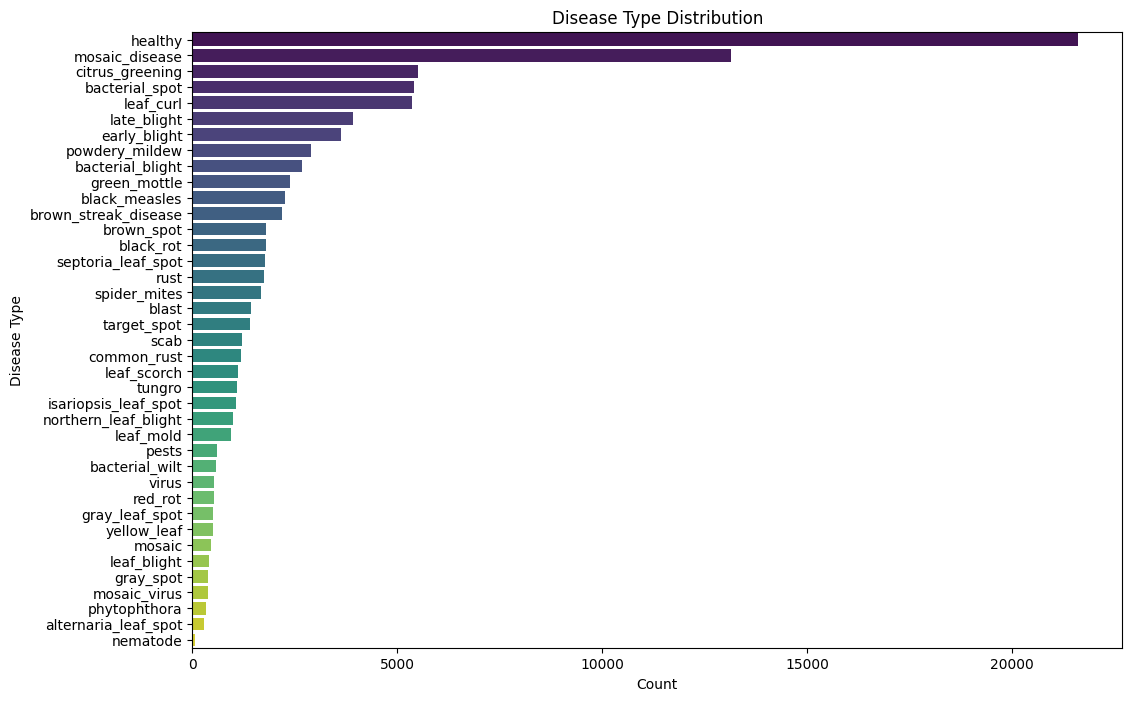

In [19]:
# Plot count plot for 'disease_type'
plt.figure(figsize=(12, 8))
sns.countplot(y='disease_type', data=df, order=df['disease_type'].value_counts().index, palette='viridis')
plt.title('Disease Type Distribution')
plt.xlabel('Count')
plt.ylabel('Disease Type')
plt.show()

Some observations
- `healthy` is the biggest class. We expected that, since it includes images for all different plants.
- Some diseases are called very similar, e.g. `mosaic_disease`, `mosaic` and `mosaic_virus`. We'll do some research if they can be combined later on.
- Overall the data is very unbalanced. We'll tackle this later on.

## 2.3. Images

To get example images for each class, one can use the code below. It's commented out because it will make this notebook really long. Use it at your own discretion.

In [ ]:
'''
# Display sample images from each class
class_folders = os.listdir(DATASET_PATH)
for class_folder in class_folders:
    class_path = os.path.join(DATASET_PATH, class_folder)
    sample_image = os.listdir(class_path)[0]
    image_path = os.path.join(class_path, sample_image)
    # Display the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Class: {class_folder}")
    plt.show()
'''

Let's have a look at the image sizes next.

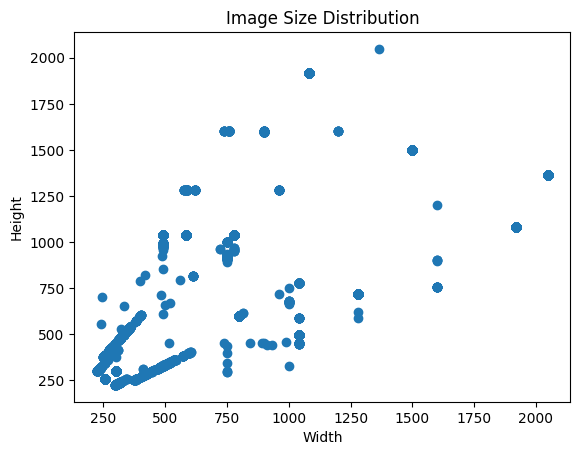

In [22]:
image_sizes = df['image_path'].apply(lambda x: Image.open(x).size)
width, height = zip(*image_sizes)

# Plot the image size distribution
plt.scatter(width, height)
plt.title('Image Size Distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

This plot shows that we have all kinds of image resolutions. This can be an issue since most pretrained CNN models work best when we use images with the same dimensions as the ones the model has been trained with. As a consequence, we have to resize the images we use. Let's have a close look at that.

In [23]:
# List the different image sizes in our dataset

df['image_path'].apply(lambda x: Image.open(x).size).value_counts()

image_path
(256, 256)      60409
(800, 600)      21397
(300, 300)       4624
(1500, 1500)     2328
(2048, 1365)     1729
                ...  
(240, 553)          1
(520, 671)          1
(323, 525)          1
(913, 440)          1
(750, 909)          1
Name: count, Length: 429, dtype: int64

This is an indicator that we should crop the images prior to resizing them. Let's examine further.

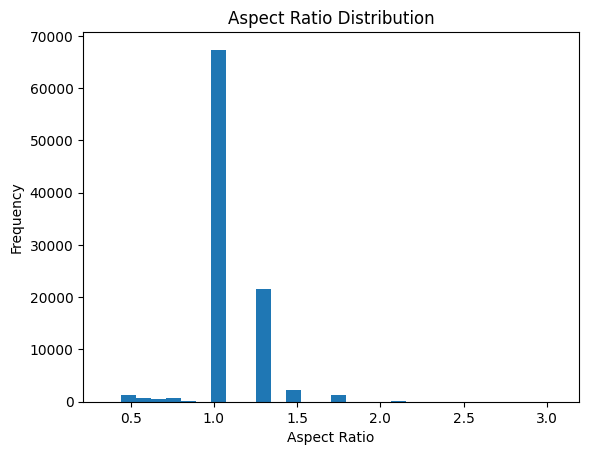

In [24]:
# Show the aspect ratio of the different images in our dataset
aspect_ratios = df['image_path'].apply(lambda x: Image.open(x).size[0] / Image.open(x).size[1])
plt.hist(aspect_ratios, bins=30)
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.show()

Yes, we definitely have to crop the images before scaling them as to not get distorted, unrealistic images. Luckily this is very easy to achieve with tensorflow.

Finally, let's check the color distribution of our images to see if something catches our eyes.

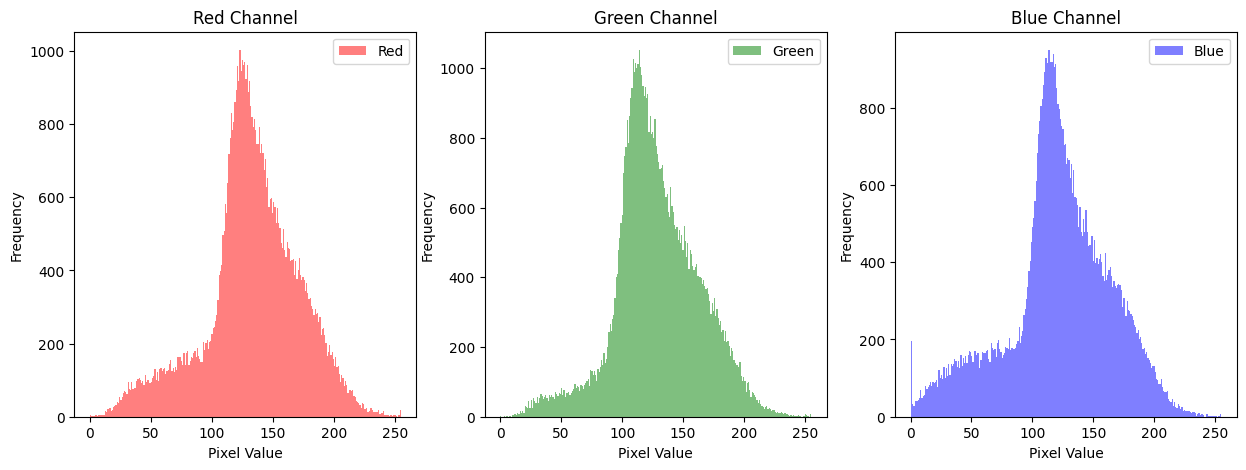

In [6]:
# Check the distribution of pixel values in the corresponding color channel for a single image
plot_color_distribution(df['image_path'].iloc[0])

## 2.4 Train-Test-Split

The next step is to do the train test split. We'll make a folder called `train` for the training data, and a new folder called `test`for the testing data, both within the `data` directory. We'll then copy 80% of the whole data to the training and 20% to testing. Validation data that is used during training of the model will be taken from the training data. This will be done in tensorflow later on.

In [16]:
# Split data into features (image paths) and labels (classes)
X = df['image_path']
y = df['disease_type']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

# Define paths for the training and testing data folders
train_dir = '../data/train/'
test_dir = '../data/test/'

# Create directories if they don't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Copy images to the training folder
for image_path, label in zip(X_train, y_train):
    dest_folder = os.path.join(train_dir, label)
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    shutil.copy(image_path, dest_folder)

# Copy images to the testing folder
for image_path, label in zip(X_test, y_test):
    dest_folder = os.path.join(test_dir, label)
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    shutil.copy(image_path, dest_folder)